In [ ]:
%run preamble_2.py
%matplotlib inline

!mkdir -p images tables results

from IPython.display import HTML

In [ ]:
#
# /getStats Dataset
#
DS_NAME="API Latencies"
FILENAME="datasets/{}-{}.npy".format(6 * 7 * 24, 60 * 10)
DS_DATA = np.load(FILENAME, allow_pickle=True)
DS_QUANTILES = [0, .25, 0.5, 0.75, .9, .95, .99, .995, .999, .9999, .99999, 1 ]

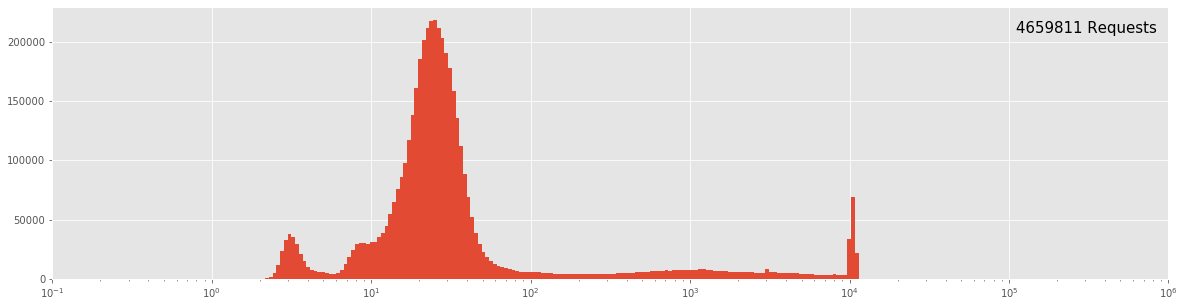

In [3]:
total = np.concatenate(DS_DATA)
ax = log_plot(total, [])
plt.savefig("images/" + DS_NAME + "_distribution")

In [4]:
CLASSES[6].thresholds = np.array([ 0, 1, 10, 100, 500, 1000, 2000, 5000, 8000, 9000, 10000, 15000 ])

METHODS_SEL = [
 'exact',
 'prom',
 'hdr',
 'tdigest',
 'dd',
 'circllhist/type-7',
]

In [5]:
STATS = evaluate_all(DS_DATA, DS_QUANTILES)

# exact
Insert .........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [6]:
# Set prom thresholds
# CLASSES[6].thresholds = 10**np.linspace(0, 5, 100)
CLASSES[6].thresholds = np.array([ 0, 1, 10, 100, 500, 1000, 2000, 5000, 8000, 9000, 10000 ])
reevaluate(STATS, "prom", DS_DATA, DS_QUANTILES)

# prom
Insert ..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [7]:
save(json.dumps(STATS), "results/" + DS_NAME + ".json")

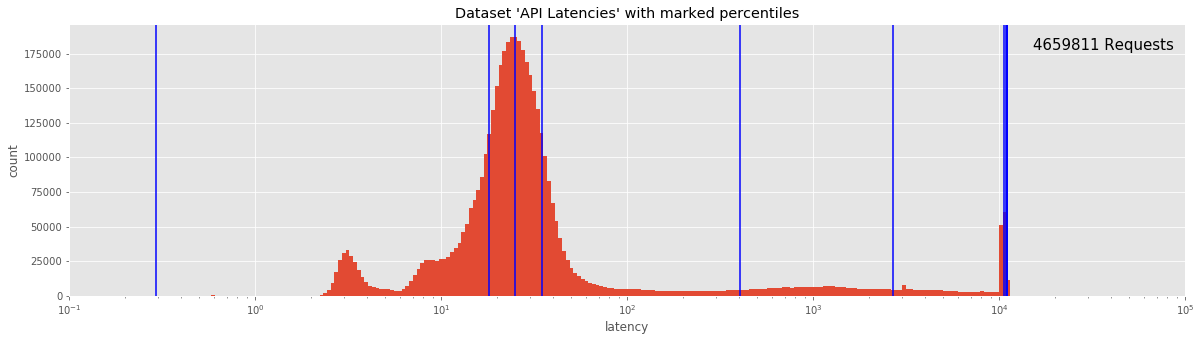

In [8]:
log_plot(total, [STATS["exact"]["quantiles"][q] for q in DS_QUANTILES ], xmax=1e5)
plt.title("Dataset '{}' with marked percentiles".format(DS_NAME))
plt.ylabel("count")
plt.xlabel("latency")
plt.savefig("images/" + DS_NAME + "_distribution_percentiles", bbox_inches="tight")

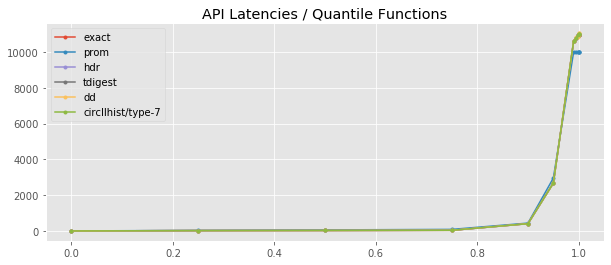

In [9]:
#
# Stats: Quantiles
#
df = stats_quantiles(STATS)[METHODS_SEL]

save(df.to_latex(), "tables/" + DS_NAME + "_quantiles.tex")

plt.figure(figsize=(10,4))
plt.title(DS_NAME + " / Quantile Functions")
for name in METHODS_SEL:
    plt.plot(DS_QUANTILES, [ STATS[name]["quantiles"][q] for q in DS_QUANTILES ] ,".-")

plt.legend(METHODS_SEL)
plt.savefig("images/" + DS_NAME + "_quantile_comparison")

In [10]:
df

,exact,prom,hdr,tdigest,dd,circllhist/type-7
q0,0.290775,0.000000,0.290665,0.290775,0.290775,0.290385
q.25,17.911811,27.346052,17.918067,17.950573,17.994143,17.911775
q.5,24.914646,56.423912,24.924232,24.914638,24.780499,24.915317
q.75,34.875410,85.501772,34.896609,34.892596,34.815697,34.875685
q.9,404.770819,438.082141,404.800668,410.364935,407.544587,404.748022
q.95,2670.851152,2954.927197,2671.469658,2695.063664,2671.012821,2670.348510
q.99,10600.161716,10000.000000,10603.415260,10593.161512,10617.501634,10611.333061
q.995,10788.963851,10000.000000,10795.829795,10786.155686,10831.996616,10805.658190
q.999,10939.060919,10000.000000,10940.140696,10935.791336,10831.996616,10961.124966
q.9999,10972.372995,10000.000000,10974.500435,10971.552113,11050.824831,10996.104990


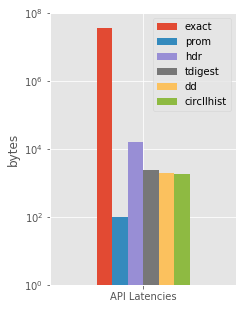

In [11]:
#
# Stats: Size
#
df = stats_size(STATS)[METHODS_SEL].rename({"bsize" : DS_NAME }).rename({ "circllhist/type-7" : "circllhist" }, axis=1)

save(df.to_latex(), "tables/" + DS_NAME + "_size.tex")

fig = plt.figure(figsize=(10/3,5))
ax = plt.subplot(1,1,1)
df.plot(kind="bar", ax=ax)
plt.title("")
plt.yscale("log")
plt.ylabel("bytes")
plt.xticks(rotation=0)
plt.ylim(1, 10**8)
plt.savefig("images/" + DS_NAME + "_size", bbox_inches = "tight")

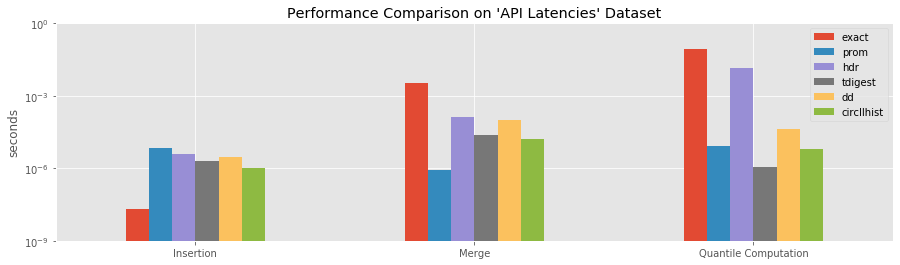

In [22]:
#
# Stast: Timing
#
df = stats_timing(STATS)[METHODS_SEL].rename({ "circllhist/type-7" : "circllhist" }, axis=1)

df.rename({ "insert" : "Insertion" , "merge" : "Merge", "quantiles" : "Quantile Computation" },inplace=True)

# table in usec
(df*10**6).to_latex("tables/" + DS_NAME + "_perf.tex", float_format = "%.1f")

fig = plt.figure(figsize=(15, 4))
ax = plt.subplot(1,1,1)
df.plot(kind="bar", ax=ax)
plt.yscale("log")
plt.ylabel("seconds")
plt.ylim(1e-9, 1e0)
plt.yticks([10**-9, 10**-6, 10**-3, 10**-0])
plt.title("Performance Comparison on '{}' Dataset".format(DS_NAME))
plt.xticks(rotation=0)
plt.savefig("images/" + DS_NAME + "_perf", bbox_inches = "tight")

In [13]:
df

,exact,prom,hdr,tdigest,dd,circllhist
Insertion,2.106887e-08,6.930927e-06,0.000004,0.000002,0.000003,0.000001
Merge,3.487584e-03,8.632552e-07,0.000135,0.000024,0.000105,0.000016
Quantile Computation,8.377316e-02,8.329093e-06,0.013963,0.000001,0.000043,0.000006


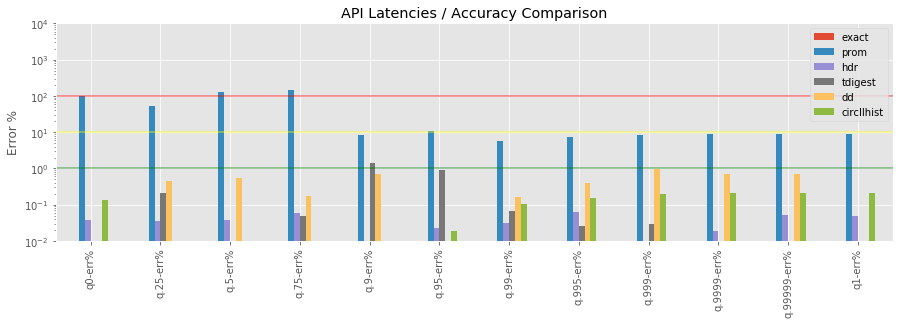

In [18]:
#
# Stats: Accuracy
#
df = stats_qerr(STATS)[METHODS_SEL].rename({ "circllhist/type-7" : "circllhist" }, axis=1)

METHODS_TBL = list(df.columns)
METHODS_TBL.remove("exact")
df[METHODS_TBL].to_latex("tables/" + DS_NAME + "_accuracy.tex", float_format="%.3f")

fig = plt.figure(figsize=(15, 4))
ax = plt.subplot(1,1,1)
plt.title(DS_NAME + " / Accuracy Comparison")
ax.axhline(1, alpha=0.5, color="green")
ax.axhline(10, alpha=0.5, color="yellow")
ax.axhline(100, alpha=0.5, color="red")
df.plot(kind="bar", ax=ax)
plt.legend(loc="upper right")
plt.yscale("log")
plt.ylabel("Error %")
plt.ylim(1e-2, 1e4)
plt.savefig("images/" + DS_NAME + "_accuracy", bbox_inches="tight")

In [15]:
df

,exact,prom,hdr,tdigest,dd,circllhist
q0-err%,0.0,100.000000,0.037812,0.000000,0.000000,0.134331
q.25-err%,0.0,52.670507,0.034926,0.216407,0.459655,0.000199
q.5-err%,0.0,126.468850,0.038477,0.000031,0.538426,0.002692
q.75-err%,0.0,145.163489,0.060786,0.049279,0.171219,0.000788
q.9-err%,0.0,8.229675,0.007374,1.382045,0.685269,0.005632
q.95-err%,0.0,10.636162,0.023158,0.906547,0.006053,0.018820
q.99-err%,0.0,5.661817,0.030693,0.066039,0.163582,0.105388
q.995-err%,0.0,7.312693,0.063639,0.026028,0.398859,0.154735
q.999-err%,0.0,8.584475,0.009871,0.029889,0.978734,0.201700
q.9999-err%,0.0,8.862012,0.019389,0.007481,0.714994,0.216289
